In [ ]:
import pickle

In [1]:
%pylab inline
import seaborn as sns
sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 25,10;
sns.set_context('poster',font_scale=1.4);
import pandas as pd;
from collections import namedtuple
from pprint import pprint;
import sys;
from copy import deepcopy;
import pickle;
import pyccl as ccl
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr

Populating the interactive namespace from numpy and matplotlib


In [11]:
%reload_ext autoreload
%autoreload 2
from fisher import Fisher, FullPlot, marginalize, plot_contours

In [3]:
obj = pickle.load(open('debuggedfisher.p','rb'))

In [31]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 5})

In [6]:
obj.makeCells??

Signature: obj.makeCells(cosmo=None)
Docstring: <no docstring>
Source:   
    def makeCells(self, cosmo=None):
        print('making C_ells')
        if not cosmo:
            cosmo = self.cosmo
        ccl_cls = pd.DataFrame()
        zbin = 0
        j = 0
        ia0 = self.A0 * np.array([self.A_l(zi, self.etal) for zi in self.zmid]) * np.array([self.A_h(zi, self.etah) for zi in self.zmid])
        lst = list(self.dNdz_dict_source.keys())
        for i, key in enumerate(lst):
            ia = self.getAi(self.beta, cosmo, dNdz=tuple(self.dNdz_dict_source[key])) * ia0
            lens1 = ccl.WeakLensingTracer(cosmo, dndz=(self.zmid, self.dNdz_dict_source[key]), ia_bias=(self.zmid, ia))
            for keyj in lst[i:]:
                ia = self.getAi(self.beta, cosmo, dNdz=tuple(self.dNdz_dict_source[keyj])) * ia0
                lens2 = ccl.WeakLensingTracer(cosmo, dndz=(self.zmid, self.dNdz_dict_source[keyj]), ia_bias=(self.zmid, ia))
                cls = ccl.angular_cl(cosmo, lens1

In [23]:
def makeCells(self, cosmo=None):
        if not cosmo:
            cosmo = self.cosmo
        ccl_cls = pd.DataFrame()
        zbin = 0
        j = 0
        ia0 = self.A0 * np.array([self.A_l(zi, self.etal) for zi in self.zmid]) * np.array([self.A_h(zi, self.etah) for zi in self.zmid])
        lst = list(self.dNdz_dict_source.keys())
        for i, key in enumerate(lst):
            ia = self.getAi(self.beta, cosmo, dNdz=tuple(self.dNdz_dict_source[key])) * ia0
            lens1 = ccl.WeakLensingTracer(cosmo, dndz=(self.zmid, self.dNdz_dict_source[key]), ia_bias=(self.zmid, ia))
            for keyj in lst[i:]:
                ia = self.getAi(self.beta, cosmo, dNdz=tuple(self.dNdz_dict_source[keyj])) * ia0
                lens2 = ccl.WeakLensingTracer(cosmo, dndz=(self.zmid, self.dNdz_dict_source[keyj]), ia_bias=(self.zmid, ia))
                cls = ccl.angular_cl(cosmo, lens1, lens2, self.ell)
                newdf = pd.DataFrame({'zbin': [int(k) for k in j*np.ones(len(cls))],
                                      'ell': self.ell,
                                      'C_ell': cls})
                ccl_cls = pd.concat((ccl_cls, newdf))
                j += 1


        self.ccl_cls = ccl_cls.reset_index()
        
        C_ells = []
        for i in set(self.ccl_cls['zbin']):
            C_ells.append(list(self.ccl_cls[self.ccl_cls['zbin']==i]['C_ell']))
        return C_ells

In [26]:
obj.makeCells = makeCells

In [24]:
redef(obj, 'makeCells', makeCells)

In [21]:
obj.makeCells??

Signature: obj.makeCells(*args, **kwargs)
Docstring: <no docstring>
Source:   
        def tocall(*args, **kwargs):
            self._capture(args, kwargs)

            # pop off the redef class variable to keep the
            # faked out function signature the same
            try:
                return func(*args, **kwargs)
            except:
                args = args[1:]
                return func(*args, **kwargs)
File:      ~/.local/lib/python3.8/site-packages/redef.py
Type:      method


In [14]:
import emcee

In [17]:
!pip install redef --user

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
  Created wheel for redef: filename=redef-1.7-py3-none-any.whl size=4890 sha256=88abbaa869d138c4a554412cdae7cb85c970d8afefac75efb8c26ba1988d29d3
  Stored in directory: /global/u2/h/husni/.cache/pip/wheels/97/3e/f5/7256d89d0921810fce911f686e5a85fbda213436b58d0b3cf1
Successfully built redef


In [5]:
import emcee

In [6]:
del sum

In [42]:
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 5})

In [41]:
data = np.array(obj.ccl_cls['C_ell']).reshape(15, 15).T
def lnprob(theta):
    cosmo = ccl.Cosmology(Omega_c=theta[1]-0.049, 
           Omega_b=0.049, 
           h=0.6727, 
           sigma8=theta[0], 
           n_s=0.9645, 
           transfer_function='eisenstein_hu')
    obj.bias = [theta[i] for i in range(2, 7)]
    obj._makeSourcePZ()
    theory = np.array(obj.makeEmceeCells(cosmo)).T;
    diff = np.array(data) - np.array(theory)
    return -sum(np.dot(diff[l], np.dot(obj.invcov_list[l], diff[l]))/2
               for l in range(15)) + lnprior(theta)

def lnprior(theta):
    X = {'sigma_8':theta[0], 'omega_m':theta[1]}
    mu = {'sigma_8':0.831, 'omega_m':0.3156}
    sigma = {'sigma_8':0.14, 'omega_m':0.2}
    for i in range(5):
        mu['zbias'+str(i)] = 0
        X['zbias'+str(i)] = theta[i+2]
        sigma['zbias'+str(i)] = 2
    return sum([
        np.log(1/(np.sqrt(2*np.pi)*sigma[i])) - (X[i]-mu[i])**2/(2*(sigma[i]**2)) for i in X.keys()
    ])


ndim = 7
nwalkers = 3
nsteps = 10
fid = np.array([0.831, 0.3156, 0, 0, 0, 0, 0])
p00 = 0.1 * np.random.randn(nwalkers, ndim) + fid
from multiprocessing import Pool
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool, backend=backend)
    sampler.run_mcmc(p00, nsteps)


ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

In [43]:
p00

array([[0.72365917, 0.24407476, 0.65723716],
       [0.85108072, 0.33471762, 0.63497717]])

In [50]:
import h5py


In [52]:
f = h5py.File('../tutorial.h5')

In [61]:
a = f['mcmc']['chain']

In [63]:
np.array(a)

array([[[0.78595718, 0.31275845, 0.6705744 ],
        [0.94016553, 0.26328141, 0.67073121],
        [0.82578319, 0.28953648, 0.61008476],
        [0.8794169 , 0.28325839, 0.67909829],
        [0.86835146, 0.32677428, 0.72122284],
        [0.7556799 , 0.34197449, 0.66322458]],

       [[0.78595718, 0.31275845, 0.6705744 ],
        [0.94016553, 0.26328141, 0.67073121],
        [0.82578319, 0.28953648, 0.61008476],
        [0.8794169 , 0.28325839, 0.67909829],
        [0.86835146, 0.32677428, 0.72122284],
        [0.7556799 , 0.34197449, 0.66322458]]])

In [ ]:
from multiprocessing import cpu_count
cpu_count()

In [49]:
data = np.array(obj.ccl_cls['C_ell']).reshape(15, 15).T
def lnprob(theta):
    cosmo = ccl.Cosmology(Omega_c=theta[1]-0.049, 
           Omega_b=0.049, 
           h=theta[2], 
           sigma8=theta[0], 
           n_s=0.9645, 
           transfer_function='eisenstein_hu')
    theory = np.array(obj.makeEmceeCells(cosmo)).T;
    diff = np.array(data) - np.array(theory)
    return -sum(np.dot(diff[l], np.dot(obj.invcov_list[l], diff[l]))/2
               for l in range(15)) + lnprior(theta)

def lnprior(theta):
    X = {'sigma_8':theta[0], 'omega_m':theta[1], 'h':theta[2]}
    mu = {'sigma_8':0.831, 'omega_m':0.3156, 'h':0.6727}
    sigma = {'sigma_8':0.14, 'omega_m':0.2, 'h':0.063}
    return sum([
        np.log(1/(np.sqrt(2*np.pi)*sigma[i])) - (X[i]-mu[i])**2/(2*(sigma[i]**2)) for i in ['sigma_8', 'omega_m', 'h']
    ])


ndim = 3
nwalkers = 6
nsteps = 2

fid = np.array([0.831, 0.3156, 0.6727])
p00 = fid + 0.05 * numpy.random.randn(nwalkers, ndim)
filename = "../tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool, backend=backend)   
    sampler.run_mcmc(p00, nsteps)


<ipython-input-49-a072191ebb4e>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -sum(np.dot(diff[l], np.dot(obj.invcov_list[l], diff[l]))/2
<ipython-input-49-a072191ebb4e>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -sum(np.dot(diff[l], np.dot(obj.invcov_list[l], diff[l]))/2
<ipython-input-49-a072191ebb4e>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return -sum(np.dot(diff[l], np.dot(obj.invcov_list[l], diff[l]))/2
<ipython-input-49-a072191ebb4e>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use

In [7]:
obj.IA_interp = pickle.load(open('IA_interp.p', 'rb'))

In [38]:
Fisher.IA_interp

AttributeError: type object 'Fisher' has no attribute 'IA_interp'

In [10]:
sampler

In [11]:
sampler.acceptance_fraction

array([0.68181818, 0.22727273, 0.40909091, 0.31818182, 0.40909091,
       0.22727273, 0.18181818, 0.63636364, 0.45454545, 0.5       ,
       0.22727273, 0.09090909, 0.36363636, 0.5       , 0.27272727,
       0.31818182])

In [13]:
a = sampler.chain

In [21]:
a = a.reshape(-1, ndim)


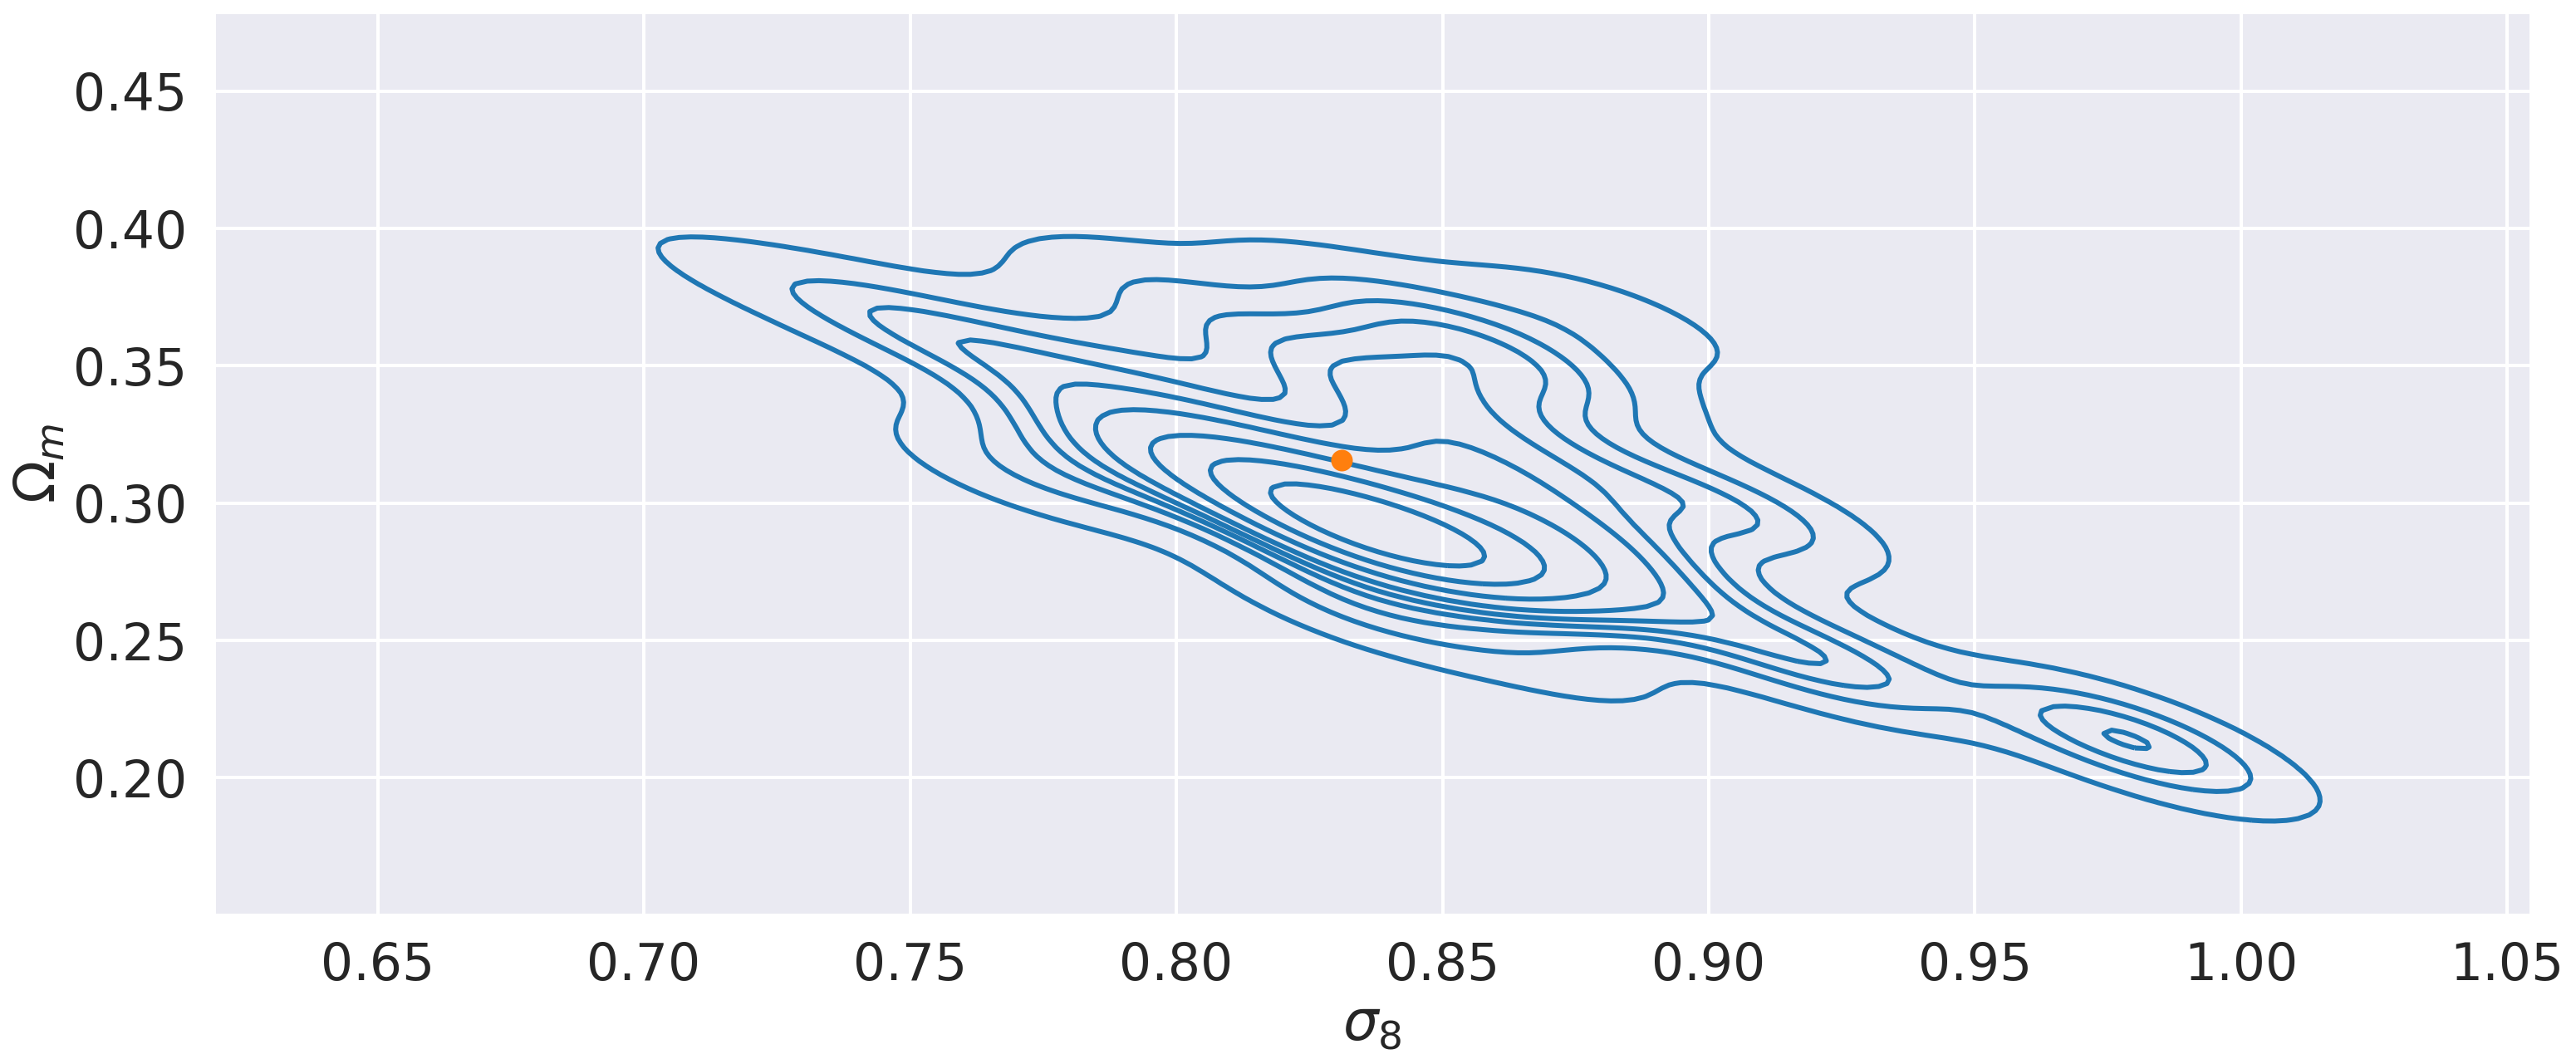

In [26]:
sns.kdeplot(x=a[:,0], y=a[:,1])
plt.xlabel(r'$\sigma_8$')
plt.ylabel(r'$\Omega_m$')
plt.plot([0.831], [0.3156], 'o')